# Mario vs Wario

## Libraries and UDFs ----

In [1]:
# Loading libraries ----

# misc
import os
import shutil
from random import sample, randint, shuffle
import math
import numpy as np
import pandas as pd
from skimage.segmentation import mark_boundaries

#sci-kit learn
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

#plots
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# youtube
from pytube import YouTube

# image operation
import cv2
from PIL import Image

# keras 
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications import inception_v3 as inc_net

# lime
import lime
from lime import lime_image

print('Notebook run using keras:', keras.__version__)

/Users/eryklewinson/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Notebook run using keras: 2.2.0


In [2]:
# UDFs ----

def scrape_frames(video_name, dest_path, n_images, skip_seconds):
    vidcap = cv2.VideoCapture(video_name)
    total_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = int(vidcap.get(cv2.CAP_PROP_FPS))
    every_x_frame = math.floor((total_frames - skip_seconds * fps) / n_images) - 1

    success,image = vidcap.read()
    frame_count = 0
    img_count = 0
    
    while success: # check success here might break your program
        success,image = vidcap.read() #success might be false and image might be None
        
        if frame_count > (skip_seconds * 30):
            # break if the video ended
            if not success:
                break

            # action on every x-th frame 
            if (frame_count % every_x_frame == 0):
                cv2.imwrite(dest_path + "_" + str(img_count) + '.jpg', image)   
                img_count += 1
                if (round(img_count / n_images, 2) * 100 % 10 == 0): 
                    print("Completed:", round(img_count / n_images, 2), "done.", end="\r")

            if img_count == n_images:
                break   
            
        frame_count += 1
        
def move_random_files(path_from, path_to, n):
    files = os.listdir(path_from)
    files.sort()
    files = files[1:] #omiting .DS_Store

    for i in sample(range(0, len(files)-1), n):
        f = files[i]
        src = path_from + f
        dst = path_to + f
        shutil.move(src, dst)
        
def preview_random_image(path):
    files = os.listdir(path)
    files.sort()
    img_name = files[randint(1, len(files) - 1)]
    img_preview_name = path + img_name
    image = Image.open(img_preview_name)
    plt.imshow(image)
    plt.title(img_name)
    plt.show()
    width, height = image.size
    print ("Dimensions:", image.size, "Total pixels:", width * height)
    
def pretty_cm(y_pred, y_truth, labels):
    cm = metrics.confusion_matrix(y_truth, y_pred)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'BuGn_r')
    # labels, title and ticks
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('Actual label')
    ax.set_title('Accuracy: {0}'.format(score), size = 15) 
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    
def img_to_1d_greyscale(img_path, size):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, size)
    return(pd.Series(img.flatten()))
    

## Downloading videos ----

In [6]:
mario_video = YouTube('https://www.youtube.com/watch?v=lXMJt5PP3kM')

In [7]:
print('Title:', mario_video.title, '---')
stream = mario_video.streams.filter(file_extension = "mp4").all()
for i in stream:
    print(i)

Title: Game Boy Longplay [005] Super Mario Land 2: 6 Golden Coins ---
<Stream: itag="18" mime_type="video/mp4" res="360p" fps="30fps" vcodec="avc1.42001E" acodec="mp4a.40.2">
<Stream: itag="133" mime_type="video/mp4" res="240p" fps="30fps" vcodec="avc1.4d400b">
<Stream: itag="160" mime_type="video/mp4" res="144p" fps="30fps" vcodec="avc1.4d400b">
<Stream: itag="140" mime_type="audio/mp4" abr="128kbps" acodec="mp4a.40.2">


In [8]:
mario_video.streams.get_by_itag(18).download()

In [9]:
wario_video = YouTube('https://www.youtube.com/watch?v=ZJuxdR0KH-s')

In [10]:
print('Title:', wario_video.title, '---')
stream = wario_video.streams.filter(file_extension = "mp4").all()
for i in stream:
    print(i)

Title: Game Boy Longplay [004] Super Mario Land 3: Wario Land ---
<Stream: itag="18" mime_type="video/mp4" res="360p" fps="30fps" vcodec="avc1.42001E" acodec="mp4a.40.2">
<Stream: itag="133" mime_type="video/mp4" res="240p" fps="30fps" vcodec="avc1.4d400d">
<Stream: itag="160" mime_type="video/mp4" res="144p" fps="30fps" vcodec="avc1.4d400c">
<Stream: itag="140" mime_type="audio/mp4" abr="128kbps" acodec="mp4a.40.2">


In [11]:
wario_video.streams.get_by_itag(18).download()

## Cutting frames from the videos ----

In [14]:
# getting frames from Mario
scrape_frames('Game Boy Longplay [005] Super Mario Land 2 6 Golden Coins.mp4', 
              'training_set/mario/mario',
              every_x_frame = 30, 
              n_images = 5000,
              skip_seconds = 60)

In [3]:
# getting frames from Wario
scrape_frames('Game Boy Longplay [004] Super Mario Land 3 Wario Land.mp4', 
              'training_set/wario/wario',
              every_x_frame = 50, 
              n_images = 5000,
              skip_seconds = 60)

## Data preprocessing ----

### splitting data into training and test sets

In [13]:
move_random_files(path_from = 'training_set/mario/', 
                  path_to = 'test_set/mario/', 
                  n = 1000)

In [14]:
move_random_files(path_from = 'training_set/wario/', 
                  path_to = 'test_set/wario/', 
                  n = 1000)

### image preview

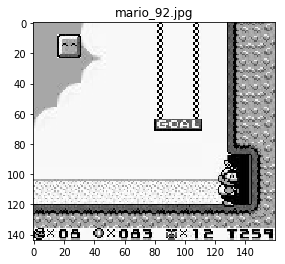

Dimensions: (160, 144) Total pixels: 23040


In [3]:
preview_random_image('training_set/mario/')

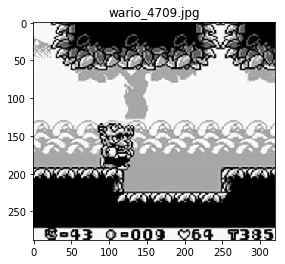

Dimensions: (320, 288) Total pixels: 92160


In [4]:
preview_random_image('training_set/wario/')

### preparing training and test sets

Used data transformations:
* rescale - value by which we will multiply the data before any other processing. Our original images consist in RGB coefficients in the 0-255, but such values would be too high for our models to process (given a typical learning rate), so we target values between 0 and 1 instead by scaling with a 1/255. factor
* shear_range - for randomly applying shearing transformations
* zoom_range - for randomly zooming inside pictures
* horizontal_flip - for randomly flipping half of the images horizontally (relevant when there are no assumptions of horizontal assymetry e.g. real-world pictures)

Source: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html



In [5]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('training_set',
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

test_set = test_datagen.flow_from_directory('test_set',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [6]:
# inspecting class labels for future reference 
training_set.class_indices

{'mario': 0, 'wario': 1}

### preview the specified transformations

In [7]:
files = os.listdir('training_set/mario/')
img_name = files[randint(0, len(files) - 1)]
    
img = load_img('training_set/mario/' + img_name)  

x = img_to_array(img)          # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in train_datagen.flow(x, batch_size=1,
                                save_to_dir='preview', save_prefix='mario', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

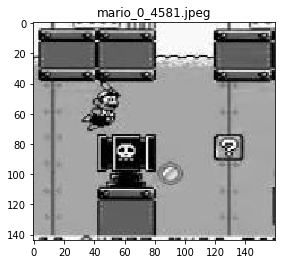

Dimensions: (160, 144) Total pixels: 23040


In [8]:
preview_random_image('preview/')

## Initialising CNN

In [7]:
# Initialising 
classifier = Sequential()

# 1st conv. layer
classifier.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# 2nd conv. layer
classifier.add(Conv2D(32, (3, 3), activation = 'relu')) #no need to specify the input shape
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Flattening
classifier.add(Flatten())

# Full connection
classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dropout(0.5)) # quite aggresive dropout, maybe reduce
classifier.add(Dense(units = 1, activation = 'sigmoid'))

classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               802944    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
__________

Dropout also helps reduce overfitting, by preventing a layer from seeing twice the exact same pattern, thus acting in a way analoguous to data augmentation (you could say that both dropout and data augmentation tend to disrupt random correlations occuring in your data).

In [8]:
# Compiling the CNN
classifier.compile(optimizer = 'rmsprop', # 'adam'/rmsprop'
                   loss = 'binary_crossentropy', 
                   metrics = ['accuracy'])

## Fitting the model

In [9]:
classifier.fit_generator(training_set,
                         steps_per_epoch = 2000,
                         epochs = 10,
                         validation_data = test_set,
                         validation_steps = 2000)

Epoch 1/10
2000/2000 [==============================] - 335s 168ms/step - loss: 0.2262 - acc: 0.8995 - val_loss: 0.3315 - val_acc: 0.8944
Epoch 2/10
2000/2000 [==============================] - 349s 174ms/step - loss: 0.0954 - acc: 0.9664 - val_loss: 0.5403 - val_acc: 0.8886
Epoch 3/10
2000/2000 [==============================] - 348s 174ms/step - loss: 0.0822 - acc: 0.9719 - val_loss: 0.2841 - val_acc: 0.9454
Epoch 4/10
2000/2000 [==============================] - 365s 183ms/step - loss: 0.0781 - acc: 0.9749 - val_loss: 0.5622 - val_acc: 0.9161
Epoch 5/10
2000/2000 [==============================] - 336s 168ms/step - loss: 0.0749 - acc: 0.9764 - val_loss: 2.0676 - val_acc: 0.7896
Epoch 6/10
2000/2000 [==============================] - 343s 172ms/step - loss: 0.0704 - acc: 0.9786 - val_loss: 0.6522 - val_acc: 0.9120
Epoch 7/10
2000/2000 [==============================] - 335s 167ms/step - loss: 0.0715 - acc: 0.9798 - val_loss: 0.3982 - val_acc: 0.9514
Epoch 8/10
2000/2000 [============

Tip from Keras blog:

Variance of the validation accuracy is fairly high, both because accuracy is a high-variance metric and because we only use 800 validation samples. A good validation strategy in such cases would be to do k-fold cross-validation, but this would require training k models for every evaluation round.

so far best 0.9821 at the last epoch without dropout:

classifier.fit_generator(training_set,
                         steps_per_epoch = 2000,
                         epochs = 10,
                         validation_data = test_set,
                         validation_steps = 2000)

In [14]:
# saving model and weights 
classifier.save_weights('mario_vs_wario_weights_dropout.h5')
v.save('mario_vs_wario_model_dropout.h5')

In [149]:
# load the model 
classifier = keras.models.load_model('mario_vs_wario_model.h5')


## Evaluating the results

In [ ]:
# Part 3 - Making new predictions

import numpy as np
from keras.preprocessing import image
test_image = image.load_img('dataset/single_prediction/cat_or_dog_1.jpg', target_size = (64, 64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = classifier.predict(test_image)
training_set.class_indices
if result[0][0] == 1:
    prediction = 'wario'
else:
    prediction = 'mario'
print(prediction)

In [11]:
num_of_test_samples = 2000
batch_size = 32

#Confution Matrix and Classification Report
Y_pred = classifier.predict_generator(test_set, num_of_test_samples // batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(metrics.confusion_matrix(test_set.classes, y_pred))
print('Classification Report')
target_names = ['mario', 'wario']
print(metrics.classification_report(test_set.classes, y_pred, target_names=target_names))

Confusion Matrix
[[1000    0]
 [1000    0]]
Classification Report
             precision    recall  f1-score   support

      mario       0.50      1.00      0.67      1000
      wario       0.00      0.00      0.00      1000

avg / total       0.25      0.50      0.33      2000



/Users/eryklewinson/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [15]:
Y_pred = classifier.predict_generator(test_set, num_of_test_samples // batch_size + 1)

## Visualising the results

On a side note I wonder why there is a difference when I rescale the image using openCV vs Keras. The openCV one for me look closer to the truth...

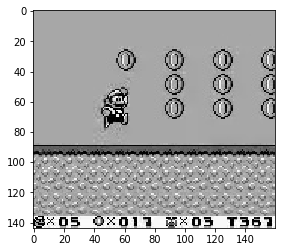

In [5]:
im = cv2.imread('training_set/mario/mario_1.jpg')
plt.imshow(im)

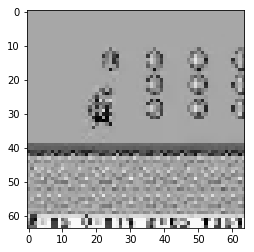

In [6]:
#using openCV
im_cv = cv2.resize(im, (64, 64)) 
plt.imshow(im_cv)

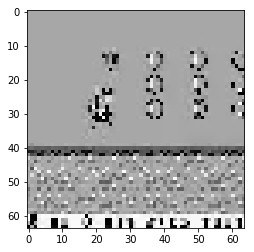

In [7]:
# using a function from Keras
im = load_img('training_set/mario/mario_1.jpg', target_size=(64, 64))
plt.imshow(im)

### Loading the model

In [ ]:
labels_index = { 0 : "mario", 1 : "wario" }

In [27]:
# Transform image for model function
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = load_img(img_path, target_size=(64, 64))
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inc_net.preprocess_input(x)
        out.append(x)
    return np.vstack(out)

# Show Image function
def show_img(image):
    fig = plt.figure(figsize = (5, 25))
    ax = fig.add_subplot(111)
    ax.imshow(image, interpolation='none')
    plt.show()



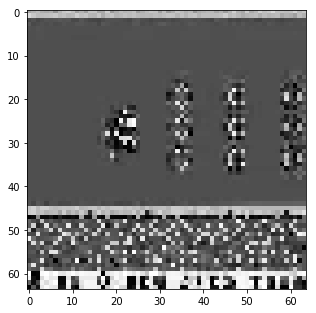

Prediction: mario


In [28]:
# Load image
mario = transform_img_fn([os.path.join('test_set/mario','mario_0.jpg')])

# Show Image Definition
show_img(mario[0])

# Show prediction
preds = classifier.predict(mario)
print("Prediction: " + labels_index[int(preds[0][0])])

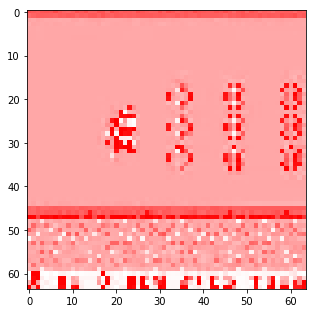

In [29]:
# Explain
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(mario[0], classifier.predict, top_labels=2, hide_color=0, num_samples=1000)
# Show image with explanation's masks
temp, mask = explanation.get_image_and_mask(0, positive_only=False, num_features=10, hide_rest=False)
show_img(mark_boundaries(temp / 2 + 0.5, mask))

In [90]:
files = os.listdir('test_set/wario/')
img_name = files[randint(0, len(files) - 1)]
    
test_image = load_img('test_set/wario/' + img_name, target_size = (64, 64))
test_image = img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = classifier.predict(test_image)

if result[0][0] == 1:
    prediction = 'wario'
else:
    prediction = 'mario'
print('Verdict:', prediction)

Verdict: mario


# Logistic Regression approach

## preparing the data

In [4]:
files = os.listdir('logistic_regression_data/')
shuffle(files)

size = (64, 64)
X = pd.DataFrame(np.zeros((len(files), size[0] * size[1])))
y = list()

In [9]:
%%time
for i in range(len(files)):
    X.iloc[i, :] = img_to_1d_greyscale('logistic_regression_data/' + files[i], size) / 255
    y.append(0 if 'mario' in files[i] else 1)

CPU times: user 10 s, sys: 572 ms, total: 10.6 s
Wall time: 10.6 s


In [47]:
# Saving data
X.to_csv('log_reg_X.csv', header = False, index = False)
pd.Series(y).to_csv('log_reg_y.csv', header = False, index = False)

In [113]:
# Loading data (if it was saved previously)
X = pd.read_csv('log_reg_X.csv', header = None)
y = pd.read_csv('log_reg_y.csv', header = None)
y =  y[0].tolist()

(10000, 1)


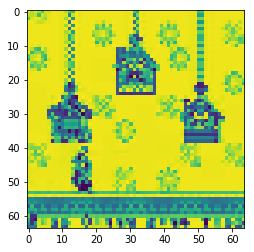

In [51]:
#example image
plt.imshow(np.reshape(X.iloc[0, ].values, size))

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify = y)

In [131]:
## training the model

In [118]:
log_reg = LogisticRegression(solver = 'lbfgs')

In [119]:
log_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

In [132]:
## making predictions

In [120]:
predictions = log_reg.predict(X_test)

In [121]:
score = log_reg.score(X_test, y_test)
print(score)

0.997


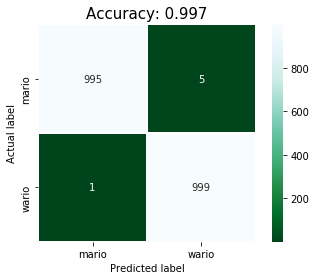

In [122]:
pretty_cm(predictions, y_test, ['mario', 'wario'])

## inspecting results

### misclassified ----

In [124]:
index = 0
misclassifiedIndexes = []
for label, predict in zip(y_test, predictions):
    if label != predict: 
        misclassifiedIndexes.append(index)
    index +=1

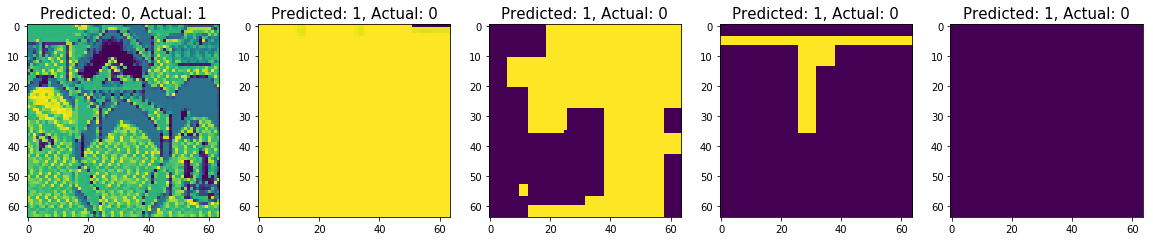

In [126]:
plt.figure(figsize=(20,4))
for plotIndex, badIndex in enumerate(misclassifiedIndexes[0:5]):
    plt.subplot(1, 5, plotIndex + 1)
    plt.imshow(np.reshape(X_test.iloc[badIndex, :].values, size))
    plt.title('Predicted: {}, Actual: {}'.format(predictions[badIndex], y_test[badIndex]), fontsize = 15)

### correctly classified ----

In [129]:
index = 0
classifiedIndexes = []
for label, predict in zip(y_test, predictions):
    if label == predict: 
        classifiedIndexes.append(index)
    index +=1
shuffle(classifiedIndexes)

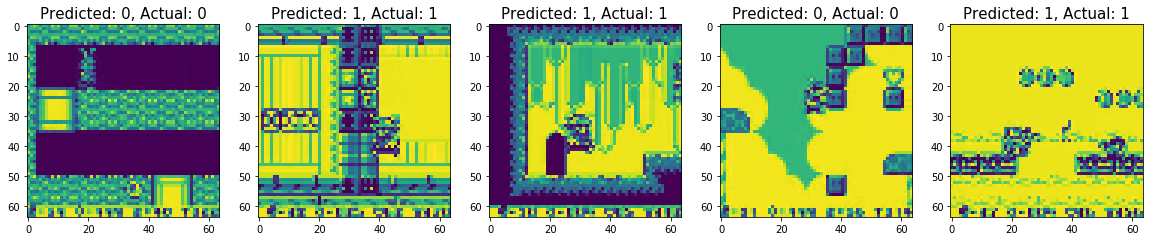

In [130]:
plt.figure(figsize=(20,4))
for plotIndex, badIndex in enumerate(classifiedIndexes[0:5]):
    plt.subplot(1, 5, plotIndex + 1)
    plt.imshow(np.reshape(X_test.iloc[badIndex, :].values, size))
    plt.title('Predicted: {}, Actual: {}'.format(predictions[badIndex], y_test[badIndex]), fontsize = 15)